In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, datetime, time
from babel.dates import format_date, format_datetime, format_time, format_timedelta, Locale
import locale                                    # para tratar de poner espanol
#locale = Locale('es', 'CL')
locale.setlocale(locale.LC_ALL,'es_ES.UTF-8')  

import os
import runpy
from pyexcel_ods import get_data

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
%matplotlib inline

#importo sólo algunas de mis funciones, dejo otras excluídas....

In [2]:
# cargo algunos scripts que me suelen servir para análisis

In [3]:
#listo los archivos
scripts = []
for dirname, dirnames, filenames in os.walk('/home/egidio/Dropbox/Compucosas/programas py'):
    for filename in filenames:
        scripts.append(os.path.join(dirname, filename))

scripts

# los cargo
for script in scripts:
    if script[-3:] == '.py':
        exec(open(str(script)).read())

['/home/egidio/Dropbox/Compucosas/programas py/lector_ODF.py',
 '/home/egidio/Dropbox/Compucosas/programas py/como importar',
 '/home/egidio/Dropbox/Compucosas/programas py/descripcion_univariada.py',
 '/home/egidio/Dropbox/Compucosas/programas py/características_operativas_de_test.py',
 '/home/egidio/Dropbox/Compucosas/programas py/percentiles.py',
 '/home/egidio/Dropbox/Compucosas/programas py/tabala_frecuencias.py',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/percentiles.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/lector_ODF.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/descripcion_univariada.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/características_operativas_de_test.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/tabala_frecuencias.cpython-36.pyc',
 '/home/egidio/Dropbox/Compucosas/programas py/__pycache__/funciones_locales.cpython-36.pyc']

# Busco las BDs diponibles

Busco las BD siponibles en la carpeta./BD, las que buscaré y las juntaré en un solo archivo

In [4]:
datos = []
for dirname, dirnames, filenames in os.walk('./BD/'):
    for filename in filenames:
        datos.append(os.path.join(dirname, filename))
datos

['./BD/SAMU 01-01-2020 al 31-01-2020.xlsx',
 './BD/SAMU 01-01-2018 al 31-12-2018.xlsx',
 './BD/eSAMU.pkl',
 './BD/SAMU 01-01-2019 al 31-12-2019.xlsx']

selecciono algunos...

In [5]:
archivos_eSAMU = [f for f in datos if '.xls' in f]

dejo todo lo que tengo como un solo objeto: BD

In [6]:
BD = pd.DataFrame()
for f in archivos_eSAMU:
    data = pd.read_excel(f)
    BD = BD.append(data)
BD.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 105517 entries, 0 to 53351
Data columns (total 44 columns):
Id                          105517 non-null int64
Fecha                       105517 non-null object
Motivo del Llamado          105510 non-null object
Submotivo del Llamado       105510 non-null object
Prioridad                   77706 non-null object
Estado                      105517 non-null object
Edad                        100613 non-null float64
Género                      100179 non-null object
Dirección                   92073 non-null object
Sector                      72378 non-null object
Comuna                      95987 non-null object
Región                      102868 non-null object
Intervención                105517 non-null object
Tipo Traslado               105517 non-null object
Categoría Vehículo          42628 non-null object
Condición Traslado          105517 non-null object
En Regulación               53493 non-null object
En Despacho                 7

# Comienzo a arreglar base de datos

dejo como numérica la edad, que lo unico que encontré

In [7]:
variables_a_numericos = [      # elijo las variables que debo transformar a numérico
    "Edad"
]

for variable in variables_a_numericos:
    BD[variable] = pd.to_numeric(BD[variable])

del variables_a_numericos

## Arreglo: Fechas

transformo a fecha tipo datetime64 la fecha que actualmente aparece

In [8]:
BD['Fecha'] = pd.to_datetime(
    BD['Fecha'],
    format='%d-%m-%Y %H:%M:%S')

In [9]:
BD['Fecha'].describe()

count                  105517
unique                  91842
top       2018-11-23 14:30:10
freq                      442
first     2018-01-15 08:45:15
last      2020-01-31 23:58:13
Name: Fecha, dtype: object

Luego defino aquellas variables que debo hacer algo similar

In [10]:
variables_a_fecha = [
    'Móvil Agregado',
    'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
    'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
    'Móvil Vuelta a Base', 'Móvil LLegada a Base',
    'Móvil Finalizado',
    'En Regulación', 'En Despacho', 'En Curso', 'Atendida', 'Completado', 'Regulado'
]

ahora lo hago

In [11]:
for variable in variables_a_fecha:
    BD[variable] = pd.to_datetime(
        BD[variable],
        format='%Y-%m-%d %H:%M:%S', 
    errors='coerce')

In [12]:
BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

BD['Diff_recep_Despachado'] = (BD['Móvil Despachado'] - BD['Fecha'])
BD['Diff_Despacho_Salida'] = (BD['Móvil Salida'] - BD['Móvil Despachado'])
BD['Diff_salida_enellugar'] = (BD['Móvil Llegada Lugar'] - BD['Móvil Salida'])
BD['Diff_z6_1'] = (BD['Móvil Camilla Retenida'] - BD['Móvil Despachado'])
BD['Diff_z6_2'] = (BD['Móvil Vuelta a Base'] - BD['Móvil Camilla Retenida'])
BD['Diff_z6_3'] = (BD['Móvil LLegada a Base'] - BD['Móvil Camilla Retenida'])

In [13]:
tiempos = ['Fecha',
           'Móvil Agregado',
           'Móvil Despachado', 'Móvil Salida', 'Móvil Llegada Lugar',
           'Móvil en Traslado', 'Móvil Llegada a CA', 'Móvil Recepción Paciente', 'Móvil Camilla Retenida',
           'Móvil Vuelta a Base', 'Móvil LLegada a Base',
           'Móvil Finalizado']

diferenciales = ['Diff_recep_Despachado',
                 'Diff_Despacho_Salida',
                 'Diff_salida_enellugar',
                 'Diff_z6_1',
                 'Diff_z6_2', 
                 'Diff_z6_3']

tiempos.append('Nombre Vehículo')
tiempos.append('Id')

BD[tiempos].head(2)
BD[diferenciales].head(2)

,Fecha,Móvil Agregado,Móvil Despachado,Móvil Salida,Móvil Llegada Lugar,Móvil en Traslado,Móvil Llegada a CA,Móvil Recepción Paciente,Móvil Camilla Retenida,Móvil Vuelta a Base,Móvil LLegada a Base,Móvil Finalizado,Nombre Vehículo,Id
0,2020-01-31 23:58:13,NaT,2020-02-01 03:01:35,2020-02-01 03:02:46,2020-02-01 03:06:23,NaT,NaT,NaT,NaT,2020-02-01 03:09:33,2020-02-01 03:25:32,2020-02-01 03:25:38,R23,131301
1,2020-01-31 23:29:08,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaT,NaN,131300


,Diff_recep_Despachado,Diff_Despacho_Salida,Diff_salida_enellugar,Diff_z6_1,Diff_z6_2,Diff_z6_3
0,03:03:22,00:01:11,00:03:37,NaT,NaT,NaT
1,NaT,NaT,NaT,NaT,NaT,NaT


count                  105517
unique                  91842
top       2018-11-23 14:30:10
freq                      442
first     2018-01-15 08:45:15
last      2020-01-31 23:58:13
Name: Fecha, dtype: object

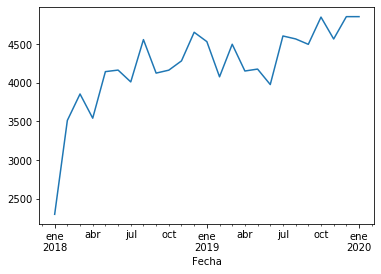

In [14]:
BD.Fecha.describe()
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()

## Arreglo: números negativos segun tiempos

Dado los cálculos realizados, encuentro que hay diferencias horarias que son negativas, que no explican lo que está pasando. por lo que quiero saber cuantos n negativos existen

In [15]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))

,n,%
Diff_recep_Despachado,,
False,105517,100.0
Total,105517,100.0


,n,%
Diff_Despacho_Salida,,
False,105514,100.0
True,3,0.0
Total,105517,100.0


,n,%
Diff_salida_enellugar,,
False,105463,99.95
True,54,0.05
Total,105517,100.00


,n,%
Diff_z6_1,,
False,105514,100.0
True,3,0.0
Total,105517,100.0


,n,%
Diff_z6_2,,
False,104980,99.49
True,537,0.51
Total,105517,100.00


,n,%
Diff_z6_3,,
False,104260,98.81
True,1257,1.19
Total,105517,100.00


Ahora excluiré aquellas entradas con valores negativos de la BD

In [16]:
for dumm in diferenciales:
    BD.loc[BD[dumm] < pd.Timedelta('0 days'),dumm] = np.nan

Ahora veré los tiempos sin contaminación

In [17]:
for dumm in diferenciales:
    tab_frec(BD[dumm] < pd.Timedelta(0))
    BD[dumm].describe()

,n,%
Diff_recep_Despachado,,
False,105517,100.0
Total,105517,100.0


count                     50116
mean     0 days 04:19:18.169686
std      0 days 03:38:54.946207
min             0 days 03:00:07
25%             0 days 03:09:17
50%      0 days 03:50:36.500000
75%             0 days 04:23:12
max            13 days 18:06:32
Name: Diff_recep_Despachado, dtype: object

,n,%
Diff_Despacho_Salida,,
False,105517,100.0
Total,105517,100.0


count                     39830
mean     0 days 00:07:51.595229
std      0 days 00:18:49.292203
min             0 days 00:00:02
25%             0 days 00:00:47
50%             0 days 00:03:03
75%             0 days 00:07:50
max             1 days 02:44:39
Name: Diff_Despacho_Salida, dtype: object

,n,%
Diff_salida_enellugar,,
False,105517,100.0
Total,105517,100.0


count                     31914
mean     0 days 00:15:39.535940
std      0 days 00:21:02.050515
min             0 days 00:00:01
25%             0 days 00:05:03
50%             0 days 00:10:28
75%             0 days 00:18:34
max             0 days 15:34:05
Name: Diff_salida_enellugar, dtype: object

,n,%
Diff_z6_1,,
False,105517,100.0
Total,105517,100.0


count                      5549
mean     0 days 01:41:20.029735
std      0 days 01:02:45.566933
min             0 days 00:00:03
25%             0 days 01:02:42
50%             0 days 01:26:46
75%             0 days 02:01:20
max             0 days 12:34:30
Name: Diff_z6_1, dtype: object

,n,%
Diff_z6_2,,
False,105517,100.0
Total,105517,100.0


count                       820
mean     0 days 01:52:00.432926
std      0 days 02:20:01.097582
min             0 days 00:00:02
25%      0 days 00:16:44.250000
50%             0 days 01:04:37
75%             0 days 02:28:05
max             0 days 15:18:50
Name: Diff_z6_2, dtype: object

,n,%
Diff_z6_3,,
False,105517,100.0
Total,105517,100.0


count                      2076
mean     0 days 02:12:15.414258
std      0 days 02:26:52.024202
min             0 days 00:00:02
25%      0 days 00:35:38.500000
50%      0 days 01:23:22.500000
75%      0 days 02:56:02.750000
max             1 days 04:20:28
Name: Diff_z6_3, dtype: object

# Esporto la BD

In [18]:
BD.to_pickle('./BD/eSAMU.pkl')

# Datos generales

In [19]:
BD.columns

Index(['Id', 'Fecha', 'Motivo del Llamado', 'Submotivo del Llamado',
       'Prioridad', 'Estado', 'Edad', 'Género', 'Dirección', 'Sector',
       'Comuna', 'Región', 'Intervención', 'Tipo Traslado',
       'Categoría Vehículo', 'Condición Traslado', 'En Regulación',
       'En Despacho', 'En Curso', 'Atendida', 'Completado', 'Regulado',
       'Usuario que Cierra', 'Móvil Agregado', 'Móvil Despachado',
       'Móvil Salida', 'Móvil Llegada Lugar', 'Móvil en Traslado',
       'Móvil Llegada a CA', 'Móvil Recepción Paciente',
       'Móvil Camilla Retenida', 'Móvil Vuelta a Base', 'Móvil LLegada a Base',
       'Móvil Finalizado', 'Nombre Vehículo', 'Tipo Requerido',
       'Tipo Despachado', 'Km Recorrido', 'Chofer', 'Paramédico', 'Enfermero',
       'Doctor', 'Longitud', 'Latitud', 'Diff_recep_Despachado',
       'Diff_Despacho_Salida', 'Diff_salida_enellugar', 'Diff_z6_1',
       'Diff_z6_2', 'Diff_z6_3'],
      dtype='object')

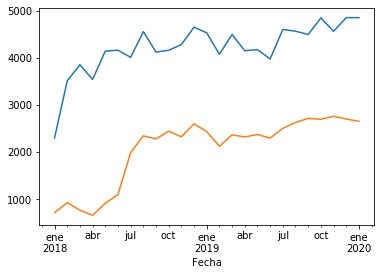

In [20]:
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()
BD.groupby(BD.Fecha.dt.to_period('M'))['Nombre Vehículo'].count().plot()

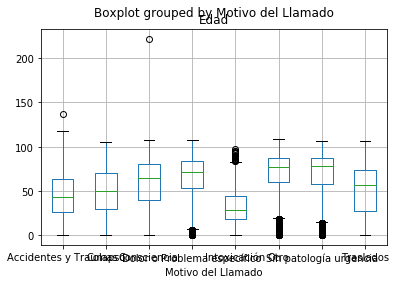

In [21]:
BD.boxplot('Edad', by = 'Motivo del Llamado')

cantidad de REM ingresados a eSAMU

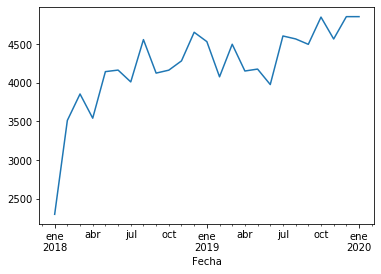

In [22]:
BD.groupby(BD.Fecha.dt.to_period('M')).Id.count().plot()

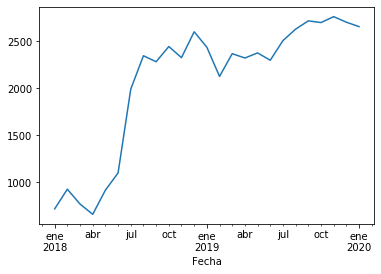

In [23]:
BD.groupby(BD.Fecha.dt.to_period('M'))['Nombre Vehículo'].count().plot()
# BD